In [179]:
import os
import math
import pickle
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pylab as plt
from math import exp, sqrt, pi
from scipy.optimize import fsolve
from scipy.special import erf, erfc
from matplotlib.ticker import MaxNLocator
from matplotlib.font_manager import FontProperties
font_props = FontProperties(family='Times New Roman', size=10)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [180]:
# Loading variables from "Data load.ipynb"
with open('variabler.pkl', 'rb') as f:
    countries, maturity, Interest_rates, ALP1, ALP2, ALP3, ALP4, ALP5, ALP6, MDY, SY, RHO, SE, BSY, DY, max_average_3, max_average_5, max_1 = pickle.load(f)  
    
######################################## Variables in "variabler.pkl" ########################################
# Countries         — List of the 26 countries in EUROSTAT order for each country
# Interest_rates    — Interest rates for AAA-ranked countries with different maturities for each country
# ALP1              — Maximum primary surplus across the entire period for each country
# ALP2              — Maximum (income) - Maximum (expenditure) across the entire period for each country
# ALP3              — Average of the dentire period for each country
# ALP4              — Time-varying (Actual) for each country
# ALP5              — 80th percentile for each country
# ALP6              — HP filter for each country
# MDY               — Mean of first GDP differences for each country
# SY                — Standard deviation of Simulated Paths
# RHO               — AR(1) parameter
# SE                — Standard errors for each country
# BSY               — Debt to GDP ratio for each country
# DY                — GDP differences for each country
# max_average_3     - Max primary surplus 3 years average
# max_average_5     — Max primary surplus 3 years average
# max_1             — Max primary surplus (Whole period (Same as ALP1))

In [181]:
# Setting variables
N = len(ALP1)           # Number of countries
initial_guess = -0.5    # Initial guess for minimization function
num_points = 10000      # Simulation parameter (linspace)
#maturity = 2           # Maturity period
T_0_new = 2000          # Initial year   
T_new = 2022            # End year

# x = 
# print(np.mean(list(max_1.values())))
# print(np.mean(list(max_average_3.values())))
# print(np.mean(list(max_average_5.values())))

In [182]:
# Dictionaries and Arrays:
interest_rate_time_model = {}
interest_rate_mean_model = {}

ALPHA_cont ={}
ALPHA_max = {}
ALPHA_mean = {}
ALPHA_time = {}
interest_rate_0 ={}
interest_rate_1 = {}
interest_rate_2 = {}
interest_rate_3 = {}
alpha_list = {0: {}, 1: {}, 2: {}, 3: {}}           # Initialize each key as an empty dictionary
interest_rate_list = {0: {}, 1: {}, 2: {}, 3: {}}   # Initialize each key as an empty dictionary

alpha = {}
se_g = {}
g_bar_log = {}
g_bar = {}
z_opt = {}
F_CDF = {}
B_n = {}

MSB = {}
MSD = {}
z = {}
interest_rate = {}
BSYobs = {}
Probability_of_default_MSD = {}
Probability_of_default = {}


Var_output = np.zeros((N, 4))
results = np.zeros((N, 3))
results_2 = np.zeros((N, 3))
D = {}
Fm = [[] for _ in range(N)]
Laffer = [[] for _ in range(N)]
smpl1 = [year for year in range(T_0_new, T_new)]
smpl2 = [year for year in range(T_0_new, T_new+1)]
ALP = {}
DATA = []
resm = []  
resb = []  

In [183]:
# max_average_3[countries[0]]
# max_average_5[countries[i]]
# max_1[countries[i]]
# print(np.mean(list(max_1.values())))
# print(np.mean(list(max_average_3.values())))
# print(np.mean(list(max_average_5.values())))
x=0
for i in range(0, len(countries)):
    print(countries[i],"    ",round(np.quantile(max_average_3[countries[i]], 0.8)*100,2))
    
    x = x + np.quantile(max_average_3[countries[i]], 0.8)

print(x/26*100)


Belgium      6.4
Bulgaria      3.6
Czechia      1.8
Denmark      6.83
Germany      2.5
Estonia      2.47
Ireland      3.27
Greece      4.03
Spain      3.37
France      0.97
Croatia      2.63
Italy      3.03
Cyprus      3.83
Latvia      0.5
Lithuania      1.5
Luxembourg      4.7
Hungary      1.83
Netherlands      2.53
Austria      2.1
Poland      0.63
Portugal      2.33
Romania      0.5
Slovenia      2.5
Slovakia      0.23
Finland      7.73
Sweden      4.17
2.9230769230769234


In [184]:
# Choosing the interest rate based on the maturity 
interest_rate_time = Interest_rates[maturity] 
#interest_rate_time = interest_rate_time.apply(lambda x: 0.02 if x < 0.02 else x)

# Calculate the average interest rate, adjusting for compounding over the maturity period
interest_rate_mean_model = np.mean(interest_rate_time)
interest_rate_mean_model = ((1+interest_rate_mean_model)**(maturity))-1

# Calculate time-varying interest rates, adjusting each rate for compounding over the maturity period
for t in range(0,len(interest_rate_time)):
    interest_rate_time_model[t] = ((1+interest_rate_time[t])**(maturity))-1

# Rename 'BSY' values to 'Debt_ratio' for each country
Debt_ratio = {}
for i in range(0, len(BSY)):
    Debt_ratio[countries[i]] = BSY[countries[i]]

# Set different scenarios for primary surplus (alpha) and interest rate
for i in range(0,len(countries)):
    alpha_list[0][countries[i]] = np.zeros((len(smpl2))) + max_average_3[countries[i]]
    alpha_list[1][countries[i]] = np.zeros((len(smpl2))) + 0.04 #max_average_5[countries[i]]
    alpha_list[2][countries[i]] = np.zeros((len(smpl2))) + 0#max_1[countries[i]]
    alpha_list[3][countries[i]] = np.zeros((len(smpl2))) + 0#0.05 #(np.mean(list(max_1.values())) + np.mean(list(max_average_3.values())) + np.mean(list(max_average_5.values())))/3


for i in range(0,len(countries)):
    interest_rate_list[0][countries[i]] = np.zeros((len(smpl2))) + list(interest_rate_time_model.values())
    interest_rate_list[1][countries[i]] = np.zeros((len(smpl2))) + list(interest_rate_time_model.values())
    interest_rate_list[2][countries[i]] = np.zeros((len(smpl2))) + list(interest_rate_time_model.values())
    interest_rate_list[3][countries[i]] = np.zeros((len(smpl2))) + list(interest_rate_time_model.values()) #list(interest_rate_time_model.values())

In [185]:
# Minimization function (CDF/PDF)

def solve_iid(z, sigma):
    cdf = (1 + erf(z / sqrt(2))) / 2        # Compute the cumulative distribution function (CDF) for a standard normal at z.
    pdf = exp(-z**2 / 2) / sqrt(2 * pi)     # Compute the probability density function (PDF) for a standard normal at z.
    res = sigma * (1 - cdf) - pdf           # Calculate the result based on sigma and adjustments for CDF and PDF.
    return res                              # Return the computed value.


In [186]:
# Main model
for j in range(0,2):
    # Different scenarios for primary surplus (alpha) and interest rate
    ALPHA_LIST_var = alpha_list[j]
    INTEREST_RATE_LIST_var = interest_rate_list[j]

    for i in range(0, len(countries)):
        ########################################## STATIC MODEL  ##################################
        ############################# Setting the parameters and variable #########################
        alpha[countries[i]] = ALPHA_LIST_var[countries[i]]                      # Loading the country specific primary surplus
        interest_rate[countries[i]] = INTEREST_RATE_LIST_var[countries[i]]      # Loading the risk free interest rate
        se_g[countries[i]] = SY[countries[i]]                                   # Loading the country specific standard deviation of the growth rate
        g_bar[countries[i]] = np.log(1+MDY[countries[i]])                       # Loading the country specific mean growth rate

        ########################################## MODEL ##########################################
        z_opt[countries[i]] = fsolve(lambda Gs1: solve_iid(Gs1, se_g[countries[i]]), initial_guess)

        #B_n[countries[i]] = np.mean(alpha[countries[i]]) * exp(g_bar[countries[i]] + se_g[countries[i]] * z_opt[countries[i]]) * (1 - F_CDF[countries[i]]) / (1 + np.mean(interest_rate[countries[i]]))
        
        F_CDF[countries[i]] = (1+erf(z_opt[countries[i]]/sqrt(2)))/2

        MSB[countries[i]] = np.mean(alpha[countries[i]]) * exp(g_bar[countries[i]] + se_g[countries[i]] * z_opt[countries[i]]) * (1 - F_CDF[countries[i]]) / (1 + np.mean(interest_rate[countries[i]]) - exp(g_bar[countries[i]] + se_g[countries[i]] * z_opt[countries[i]]) * (1 - F_CDF[countries[i]]))

        MSD[countries[i]] = exp(g_bar[countries[i]]+se_g[countries[i]]*z_opt[countries[i]])*(np.mean(alpha[countries[i]])+MSB[countries[i]])
        
        z[countries[i]] = (np.log(0.01*(Debt_ratio[countries[i]].iloc[-1]/maturity)/(np.mean(alpha[countries[i]])+MSB[countries[i]]))-g_bar[countries[i]])/(se_g[countries[i]])
        ###### Orginal ovenfor:
        #z[countries[i]] = (np.log((0.01*Debt_ratio[countries[i]].iloc[-1])/(np.mean(alpha[countries[i]])+maturity*MSB[countries[i]]))-g_bar[countries[i]])/(se_g[countries[i]]/maturity)
        
        if np.all(np.imag(z[countries[i]]) == 0):
            Probability_of_default[countries[i]] = 1-(1-(1+erf(z[countries[i]]/sqrt(2)))/2) ** (1/maturity)
        else:
            Probability_of_default[countries[i]]=np.nan
    
        ########################################## MODEL OUTPUT ##################################
        Var_output[i, 0] = 100 * np.mean(alpha[countries[i]])           # Offloading data
        Var_output[i, 1] = 100 * g_bar[countries[i]] / 4                # Offloading data
        Var_output[i, 2] = 100 * SY[countries[i]]                       # Offloading data
        Var_output[i, 3] = Debt_ratio[countries[i]].iloc[-1]            # Offloading data

        results[i, 0] = 100 * maturity * MSD[countries[i]]              # Offloading data
        results[i, 2] = 100 * Probability_of_default[countries[i]]      # Offloading data

        results_2[i, 1] = 100 * maturity * MSB[countries[i]]            # Offloading data
        #results_2[i, 2] = 100 * maturity * B_n[countries[i]]            # Offloading data
        ######################################### TIME MODEL ######################################
        ############################# Setting the parameters and variable #########################
        MSB[countries[i]] = []                                      # Dictionaries and arrays:
        z[countries[i]] = [0] * len(smpl2)                          # Dictionaries and arrays:
        MSD[countries[i]] = [0] * len(smpl2)                        # Dictionaries and arrays:
        Probability_of_default[countries[i]] = [0] * len(smpl2)     # Dictionaries and arrays:
        
        ########################################## MODEL ##########################################
        for t in range(0,len(smpl2)):
            
            MSB[countries[i]].append(alpha[countries[i]][t] * exp(g_bar[countries[i]] + se_g[countries[i]] * z_opt[countries[i]]) * (1-F_CDF[countries[i]]) / (1 + interest_rate[countries[i]][t] - exp(g_bar[countries[i]] + se_g[countries[i]] * z_opt[countries[i]]) * (1-F_CDF[countries[i]])))

            MSD[countries[i]][t] = exp(g_bar[countries[i]]+se_g[countries[i]]*z_opt[countries[i]])*(alpha[countries[i]][t])+MSB[countries[i]]

            z[countries[i]][t] = (np.log((0.01 * BSY[countries[i]].values[t]/maturity) / (alpha[countries[i]][t] + MSB[countries[i]][t])) - g_bar[countries[i]]) / (se_g[countries[i]])
            ###### Orginal ovenfor:
            #z[countries[i]][t] = (np.log(0.01 * BSY[countries[i]].values[t]/(alpha[countries[i]][t]+maturity*MSB[countries[i]][t]))-g_bar[countries[i]])/(se_g[countries[i]]/maturity)
            
            if np.all(np.imag(z[countries[i]][t]) == 0):
                Probability_of_default[countries[i]][t] = 1-(1-(1+erf(z[countries[i]][t]/sqrt(2)))/2) ** (1/maturity)
            else:
                Probability_of_default[countries[i]][t]=np.nan
        
            Probability_of_default[countries[i]][t] = 100 * Probability_of_default[countries[i]][t]
        
        ########################################## MODEL OUTPUT ##################################
        DATA.append((np.arange(T_0_new, T_new + 1),                 # Offloading data
                     100*maturity*MSD[countries[i]][len(smpl2)-1],  # Offloading data
                     Probability_of_default[countries[i]]))         # Offloading data

    resm.append(results.copy())         # Offloading data
    resb.append(results_2.copy())       # Offloading data

In [187]:
# Redefine data (resm) to make it suitable for tables and plotting 

# dfs = []
# alphas = [0,1,2,3] 

# for i in range(len(resm)):
#     dff = pd.DataFrame(resm[i])
#     suffixes = [f"MSD (Alpha_{alphas[i]})", f"Probability_of_default_MSD (Alpha_{i})", f"Probability_of_default (Alpha_{i})"]
#     dff.columns = suffixes  
#     dfs.append(dff)

#     df_merged = dfs[0]
#     for i in range(1, len(dfs)):
#         df_merged = df_merged.join(dfs[i], how='right')
#         df_merged = df_merged.round(3)

#     df_resm = df_merged

# df_resm.index = [countries[i] for i in range(len(countries))]
# df_resm.drop(df_resm.columns[[1,4,7,10]], axis=1, inplace=True)

In [188]:
resb[0]

array([[  0.        , 141.54974031,   0.        ],
       [  0.        ,  65.23786862,   0.        ],
       [  0.        ,  25.55527187,   0.        ],
       [  0.        , 147.16508854,   0.        ],
       [  0.        ,  57.23815176,   0.        ],
       [  0.        ,  34.53943678,   0.        ],
       [  0.        ,  42.74824697,   0.        ],
       [  0.        ,  55.91988019,   0.        ],
       [  0.        ,  54.1388211 ,   0.        ],
       [  0.        ,  21.57957746,   0.        ],
       [  0.        ,  37.36686481,   0.        ],
       [  0.        ,  56.16413134,   0.        ],
       [  0.        ,  62.44850333,   0.        ],
       [  0.        ,   5.46444675,   0.        ],
       [  0.        ,  19.7917863 ,   0.        ],
       [  0.        , 106.85319033,   0.        ],
       [  0.        ,  25.36562505,   0.        ],
       [  0.        ,  53.95868471,   0.        ],
       [  0.        ,  46.6931913 ,   0.        ],
       [  0.        ,   7.79235

In [189]:
# Redefine data (resb) to make it suitable for tables and plotting 

dfs = []
alphas = [0,1,2,3]  

for i in range(len(resb)):
    dff = pd.DataFrame(resb[i])
    suffixes = [f"MSD (Alpha_{i})", f"Probability_of_default_MSD (Alpha_{i})", f"Probability_of_default (Alpha_{i})"]
    dff.columns = suffixes  
    dfs.append(dff)

    df_merged = dfs[0]
    for i in range(1, len(dfs)):
        df_merged = df_merged.join(dfs[i], how='right')
        df_merged = df_merged.round(3)

    df_resb = df_merged

df_resb.index = [countries[i] for i in range(len(countries))]    

******
<h2><center>Plots</center></h2>

******

In [190]:
# Redefine data (DATA) to make it suitable for plotting
dataframes = {}
combined_df = {}

# Loop through the DATA list and create a DataFrame for each entry
for i in range(len(DATA)):
    # Creating DataFrame with 'Year', 'MSD', and 'Probability_of_default'
    dff = pd.DataFrame({'Year': DATA[i][0], 
                        'MSD': [item[0] for item in DATA[i][1]], 
                        'Probability_of_default': [item[0] for item in DATA[i][2]]})   

    dataframes[i] = dff
        
# Merge DataFrames to combine data for different alpha and interest rates scenarios for each country
for i in range(len(countries)):
    temp_df = dataframes[i].merge(dataframes[i+len(countries)], how='right', on="Year", suffixes=(' (Alpha_0)', ' (Alpha_1)'))
    #temp_df = temp_df.merge(dataframes[i+len(countries)*2], how='right', on="Year", suffixes=(' (Alpha_1)', ' (Alpha_2)'))
    #temp_df = temp_df.merge(dataframes[i+len(countries)*3], how='right', on="Year", suffixes=(' (Alpha_2)', ' (Alpha_3)'))
    temp_df = temp_df.apply(lambda x: pd.to_numeric(x, errors='ignore'))
    temp_df = temp_df.round(3)
    combined_df[countries[i]] = temp_df

In [198]:
# Setting the plots parameters
Close_plots = False
Save_plots = True
path = "/Users/sebastianhejbergingesen/Documents/Københavns Universitet/Økonomi/2023-2025 Kandidat/8.Semester/Seminar – Topics in Sovereign Debt/Model/Plot"

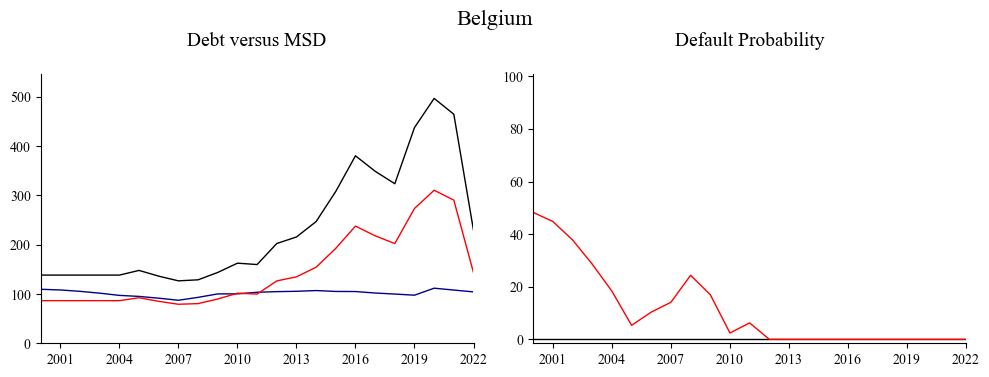

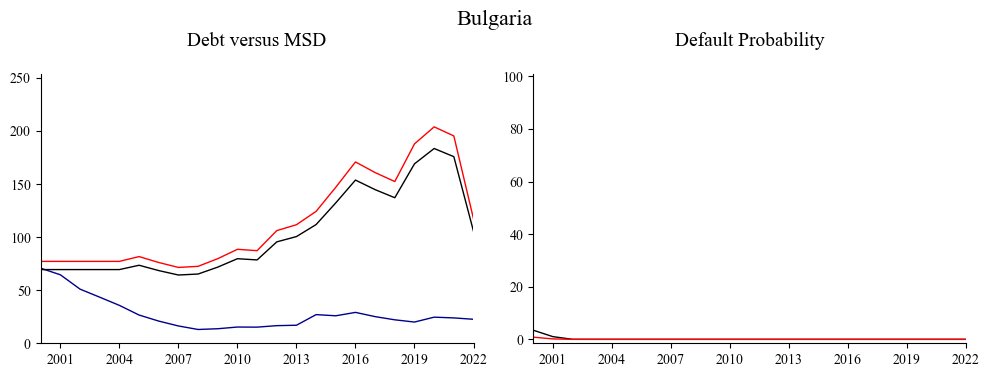

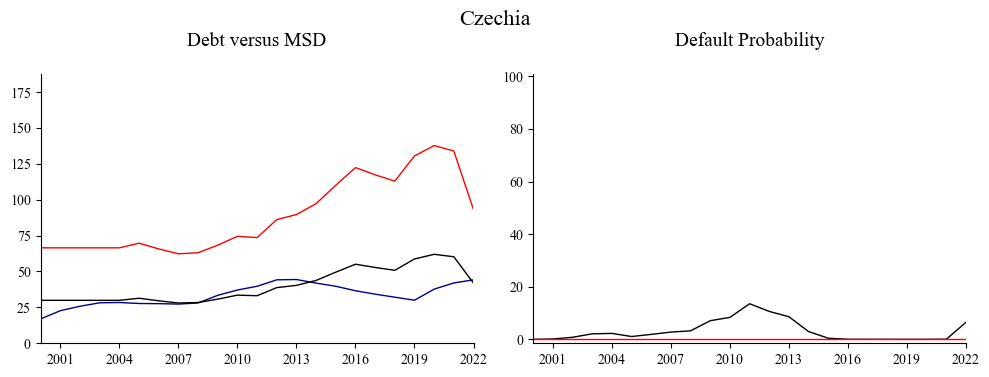

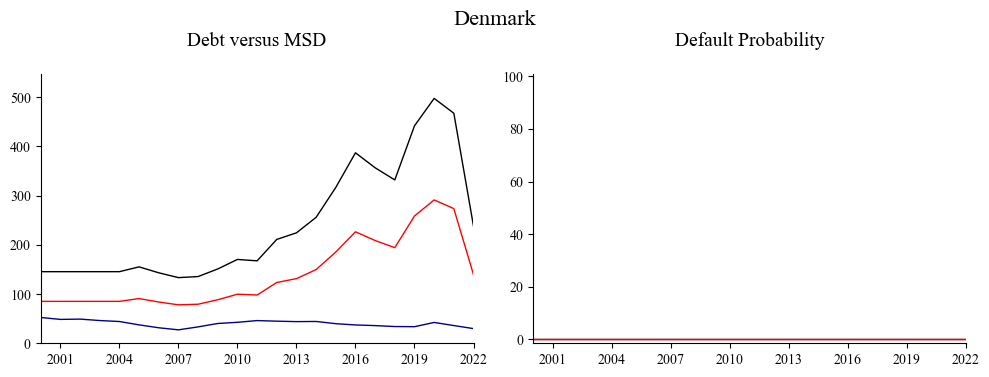

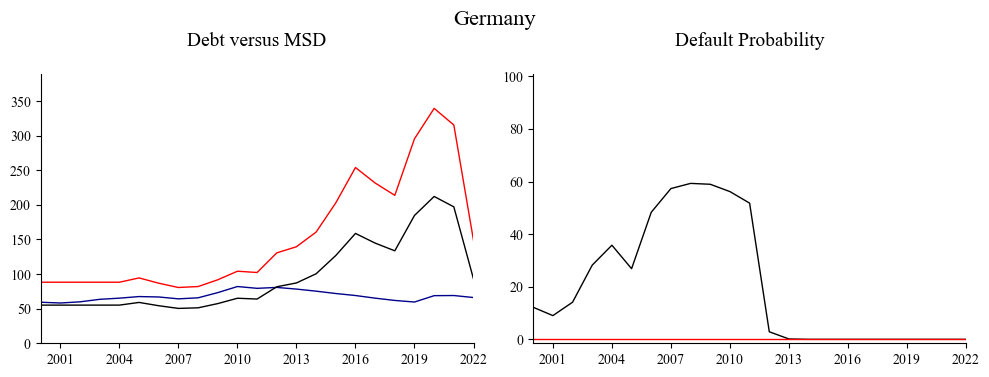

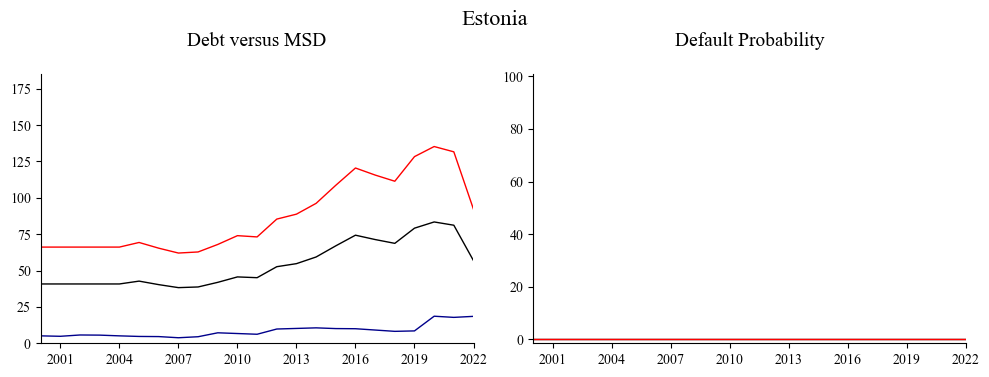

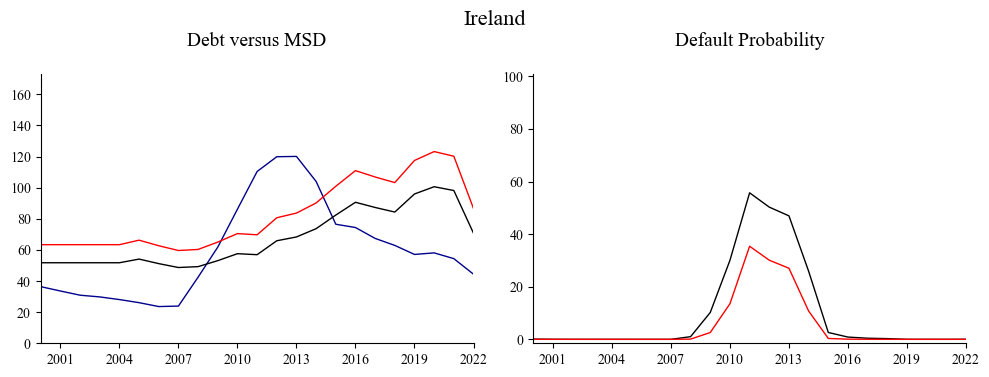

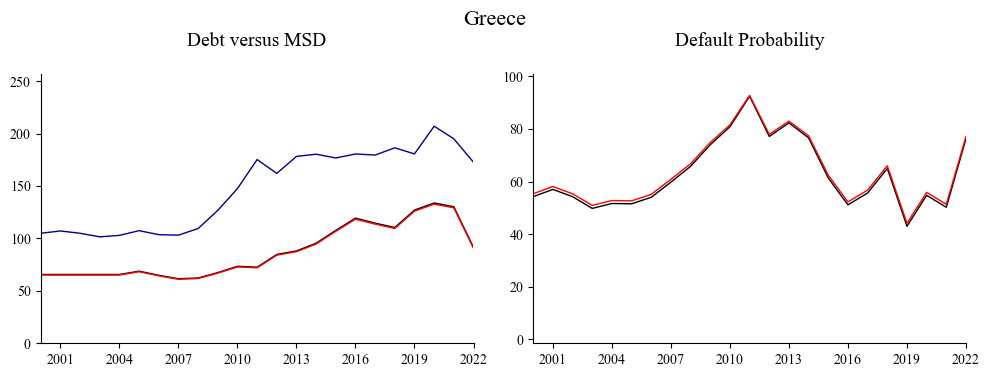

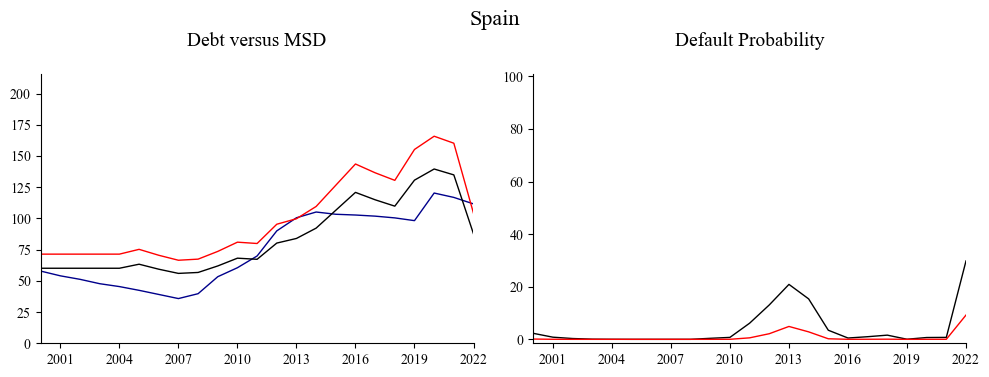

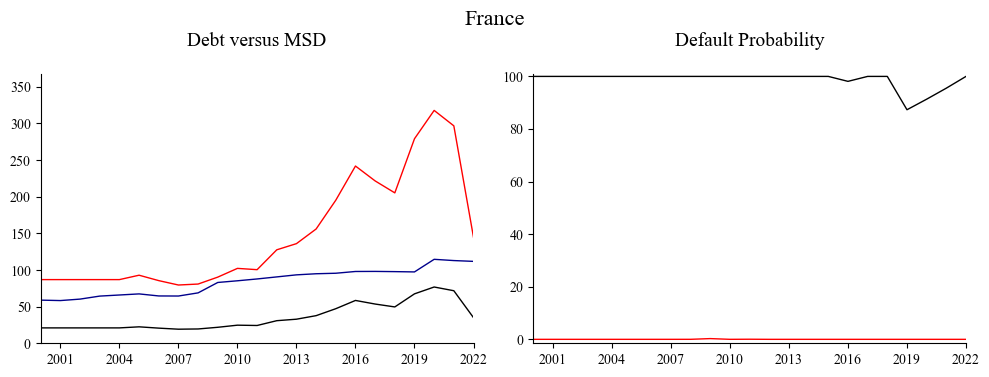

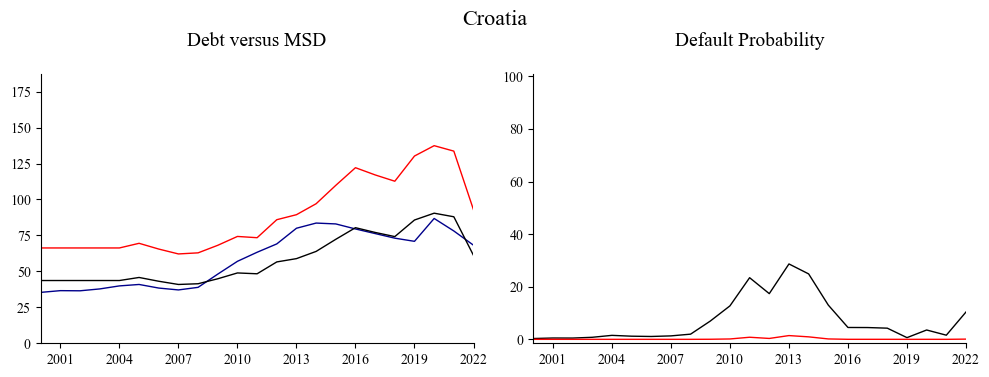

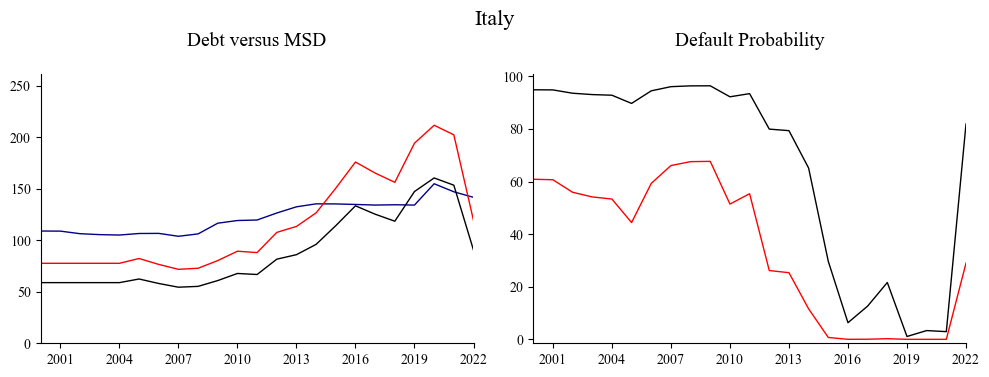

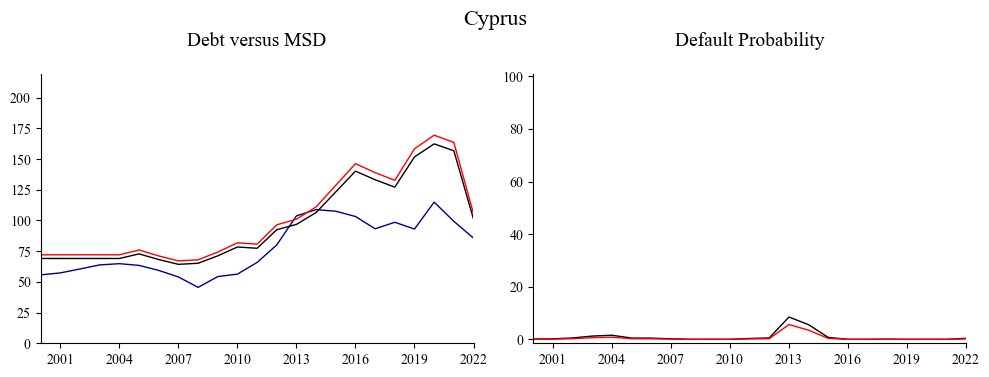

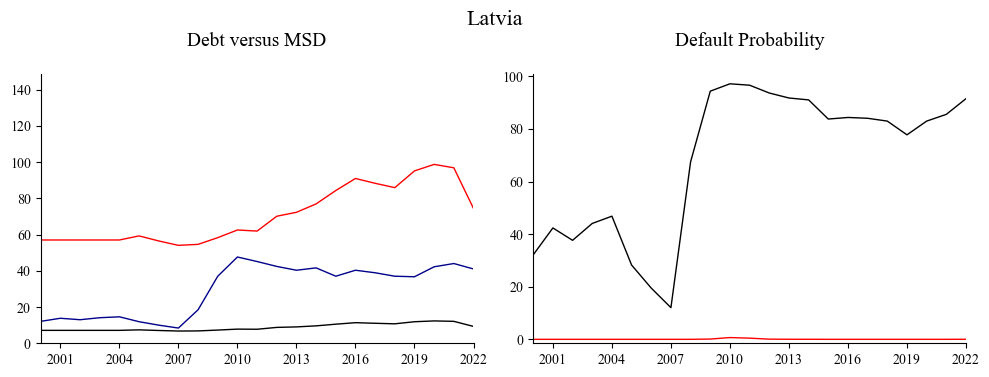

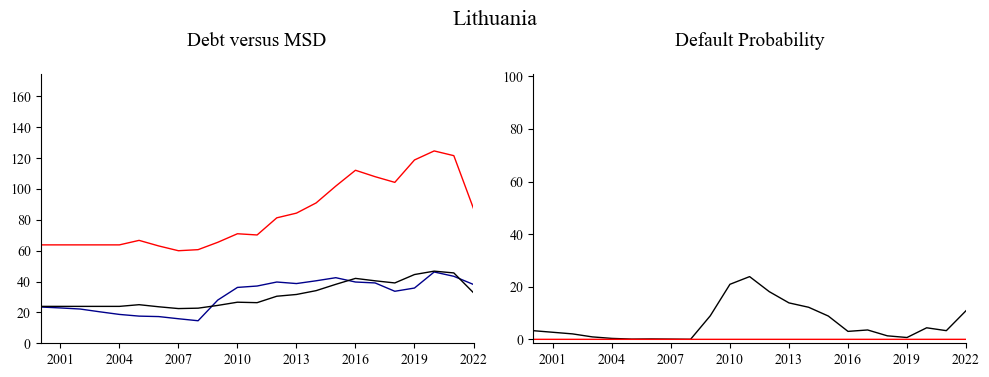

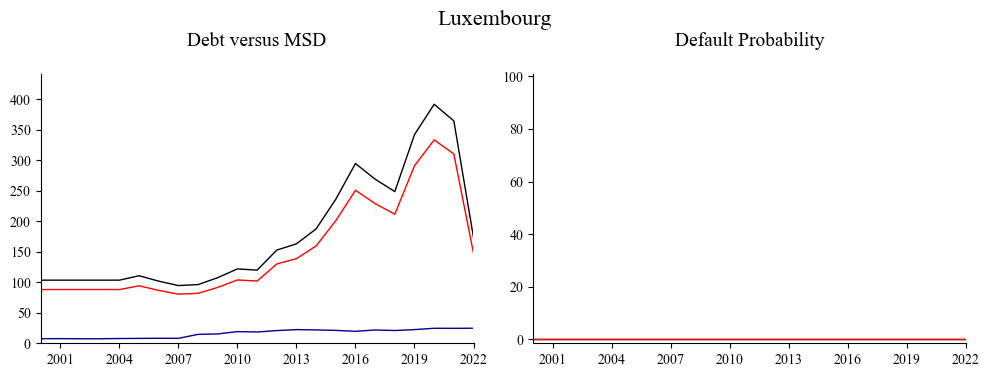

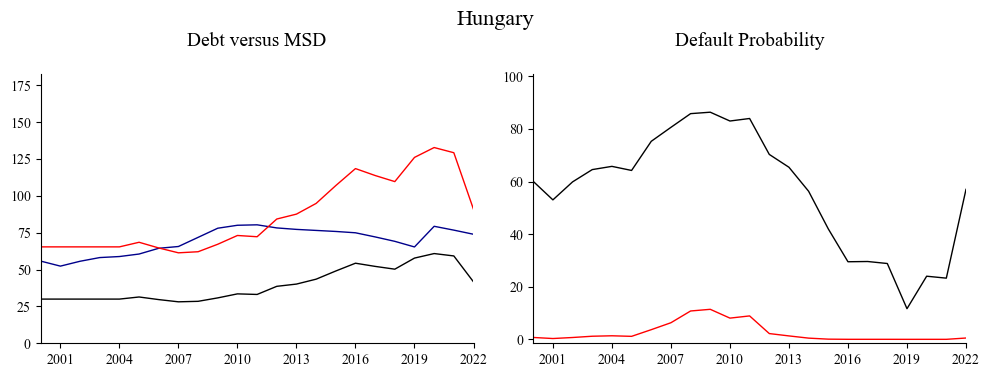

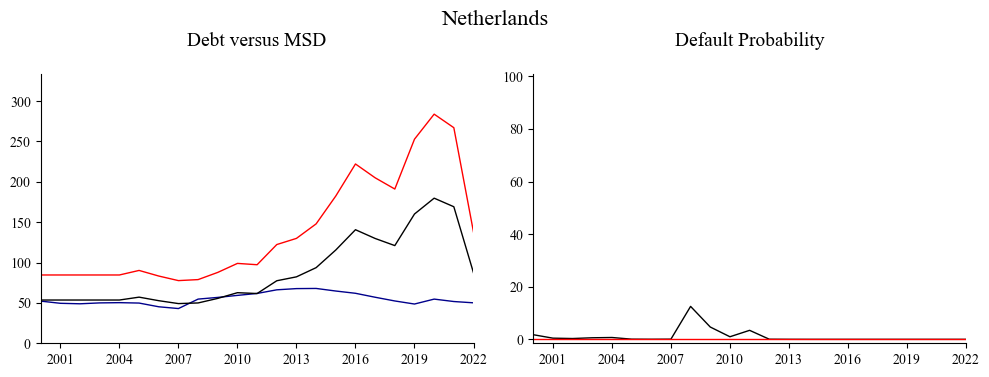

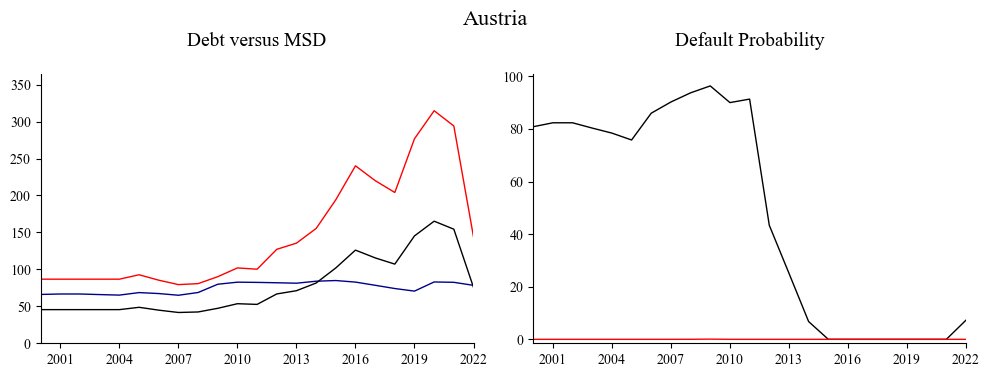

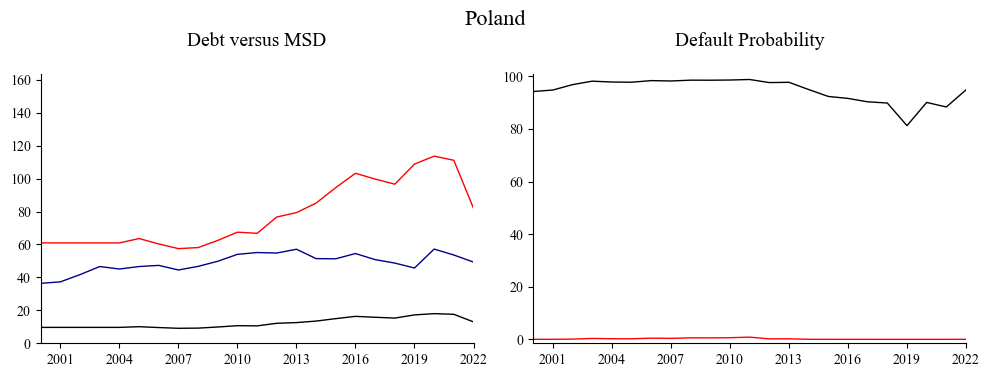

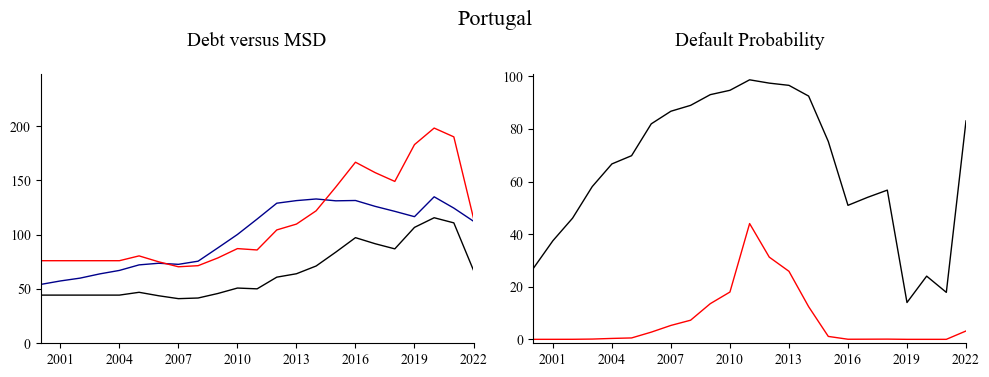

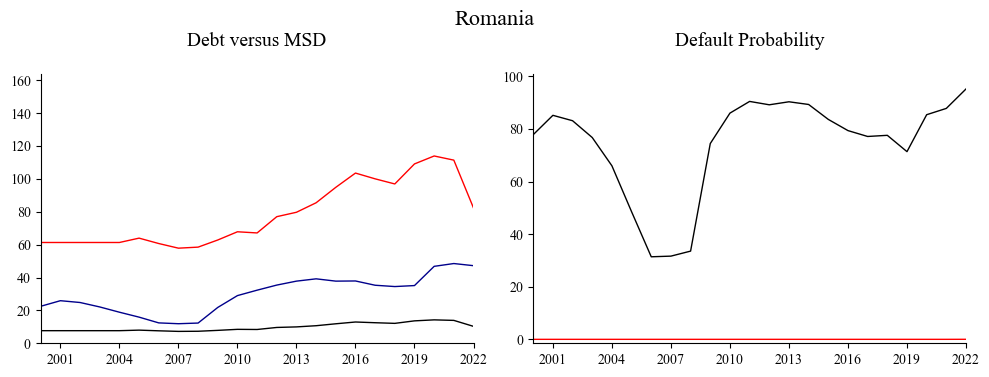

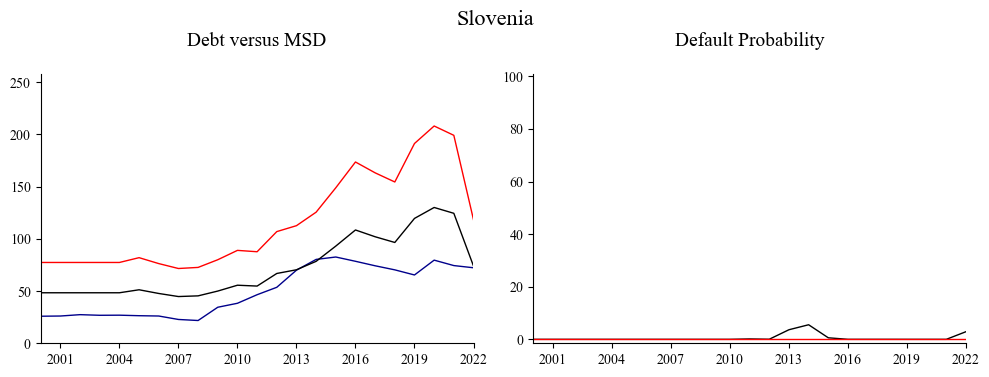

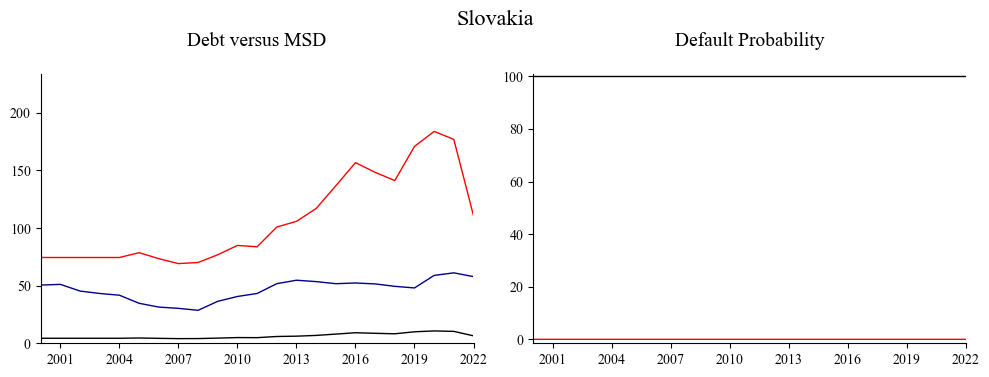

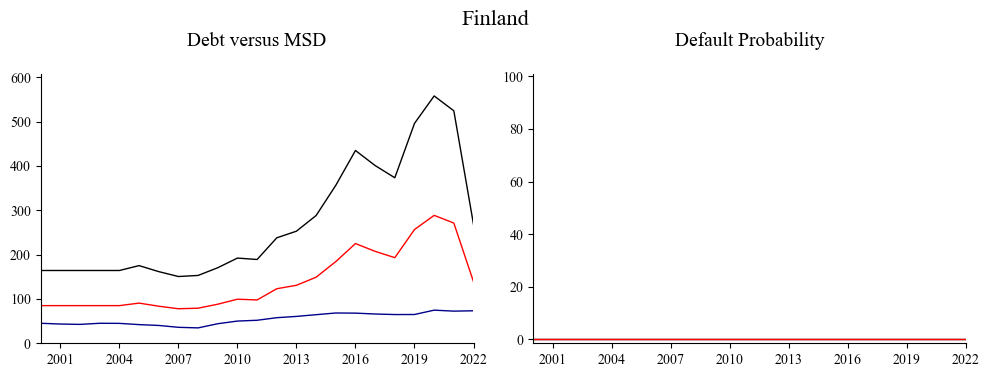

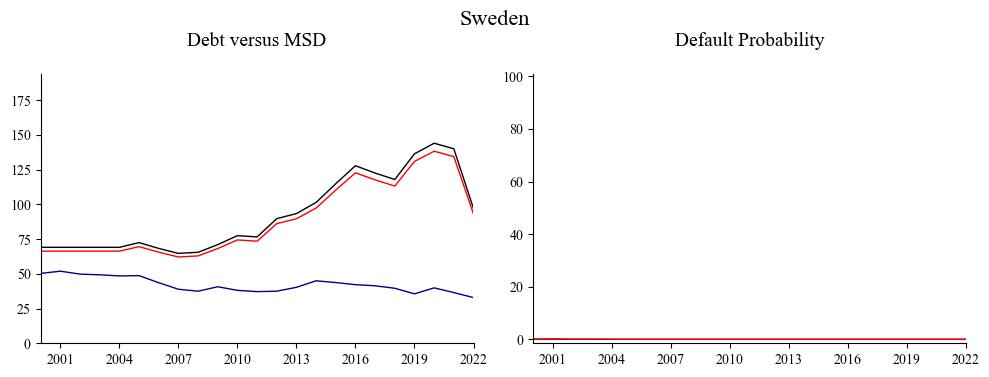

In [199]:
# Plots for each country
Debt_ratio_plot = {}
for i in range(0, len(countries)):
    Debt_ratio_plot[countries[i]] = Debt_ratio[countries[i]]

for i in  range(0, len(countries)): #[19,20,21]: #
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].plot(combined_df[countries[i]]["Year"], Debt_ratio_plot[countries[i]], color='darkblue', linestyle='-',linewidth=1)
    axs[0].plot(combined_df[countries[i]]["Year"], combined_df[countries[i]]["MSD (Alpha_0)"],          label=f"{round(np.mean(alpha_list[0][countries[i]]),4)}", color='black', linestyle='-', linewidth=1)
    axs[0].plot(combined_df[countries[i]]["Year"], combined_df[countries[i]]["MSD (Alpha_1)"].values,   label=f"{round(np.mean(alpha_list[1][countries[i]]),4)}", color='red', linestyle='-',linewidth=1)
    #axs[0].plot(combined_df[countries[i]]["Year"], combined_df[countries[i]]["MSD (Alpha_2)"].values,   label=f"{round(np.mean(alpha_list[2][countries[i]]),4)}", color='red', linestyle='-',linewidth=1)
    #axs[0].plot(combined_df[countries[i]]["Year"], combined_df[countries[i]]["MSD (Alpha_3)"].values,   label=f"{round(np.mean(alpha_list[3][countries[i]]),4)}",color='red', linestyle='--', linewidth=1)
    
    maximum = max(max(combined_df[countries[i]]["MSD (Alpha_0)"]),
                  max(combined_df[countries[i]]["MSD (Alpha_1)"]),
                  #max(combined_df[countries[i]]["MSD (Alpha_2)"]),
                  #max(combined_df[countries[i]]["MSD (Alpha_3)"]),
                  max(Debt_ratio_plot[countries[i]]))

    axs[0].set_ylim(0, maximum+50)

    axs[0].set_xlim(T_0_new, T_new)
    axs[0].set_title("Debt versus MSD", fontname='Times New Roman', size=14, pad=20)
    axs[0].tick_params(axis='x', labelsize=10)
    axs[0].tick_params(axis='y', labelsize=10)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['right'].set_color('none')
    axs[0].yaxis.tick_left()
    axs[0].spines['bottom'].set_position('zero')
    axs[0].spines['top'].set_color('none')
    axs[0].xaxis.tick_bottom()
    axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    #axs[0].legend("upper left")

    for label in axs[0].get_yticklabels():
        label.set_fontproperties(font_props)

    for label in axs[0].get_xticklabels():
        label.set_fontproperties(font_props)

    axs[1].plot(np.round(combined_df[countries[i]]["Year"]), combined_df[countries[i]]["Probability_of_default (Alpha_0)"], label='Probability_of_default (Alpha_0)',  color='black', linestyle='-',linewidth=1)
    axs[1].plot(np.round(combined_df[countries[i]]["Year"]), combined_df[countries[i]]["Probability_of_default (Alpha_1)"], label='Probability_of_default (Alpha_1)' ,  color='red', linestyle='-',linewidth=1)
    #axs[1].plot(np.round(combined_df[countries[i]]["Year"]), combined_df[countries[i]]["Probability_of_default (Alpha_2)"], label='Probability_of_default (Alpha_2)',  color='red', linestyle='-',linewidth=1)
    #axs[1].plot(np.round(combined_df[countries[i]]["Year"]), combined_df[countries[i]]["Probability_of_default (Alpha_3)"], label='Probability_of_default (Alpha_3)' ,  color='red', linestyle='--',linewidth=1)
    axs[1].set_title("Default Probability", fontname='Times New Roman', size=14)
    axs[1].tick_params(axis='x', labelsize=10)
    axs[1].tick_params(axis='y', labelsize=10)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].set_ylim(-1.5, 101)
    axs[1].set_xlim(T_0_new, T_new)
    axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    #axs[0].legend()
    for label in axs[1].get_yticklabels():
        label.set_fontproperties(font_props)

    for label in axs[1].get_xticklabels():
        label.set_fontproperties(font_props)

    plt.title("Default Probability", fontname='Times New Roman', size=14, pad=20)
    fig.suptitle(f"{countries[i]}", fontname='Times New Roman', size=16, weight='normal', y=0.93)

    plt.tight_layout()

    if Save_plots == True:
        plt.savefig(f"{path}/Main_plot_{countries[i]}.pdf", bbox_inches='tight', transparent=True)
    
    if Close_plots == True:
        plt.close(plt.gcf())
    else:
        plt.show()

******
<h2><center>Tables</center></h2>

******

In [193]:
Print_plot=[True,True,True,True,True]

In [194]:
###################### Tabel 1 ######################
#  ——— DATA: mean growth rate, the standard deviation of the growth rate, the 2010 debt-to-GDP ratio, and the historical MPS 
##########################################################################################

data = []  # Definér en tom liste til at gemme dataene max_average_3, max_average_5, max_1

for i in range(0,len(countries)):
    var_1 = g_bar[countries[i]]*100
    var_2 = se_g[countries[i]]*100
    var_3 = max_average_3[countries[i]]*100
    var_4 = max_average_5[countries[i]]*100
    var_5 = max_1[countries[i]]*100

    data.append([countries[i], var_1,var_2,round(var_3,1),var_4,var_5])

df = pd.DataFrame(data, columns=['Country', '$\mu$', '$\sigma$', "MPS 3 years", "MPS 5 years", "MPS (full period)"])

latex_output = df.to_latex(index=False, float_format="%.2f")
if Print_plot[0] == True:
    print(latex_output)

\begin{tabular}{lrrrrr}
\toprule
Country & $\mu$ & $\sigma$ & MPS 3 years & MPS 5 years & MPS (full period) \\
\midrule
Belgium & 3.44 & 7.36 & 6.40 & 5.50 & 6.80 \\
Bulgaria & 7.79 & 13.00 & 3.60 & 3.18 & 4.90 \\
Czechia & 6.24 & 17.04 & 1.80 & 1.36 & 2.20 \\
Denmark & 3.40 & 7.68 & 6.80 & 5.94 & 7.10 \\
Germany & 2.73 & 6.54 & 2.50 & 2.44 & 3.00 \\
Estonia & 7.71 & 18.47 & 2.50 & 2.40 & 3.10 \\
Ireland & 6.77 & 19.52 & 3.30 & 2.74 & 6.70 \\
Greece & 1.66 & 14.37 & 4.00 & 2.64 & 4.30 \\
Spain & 3.27 & 12.33 & 3.40 & 2.78 & 3.80 \\
France & 2.60 & 6.79 & 1.00 & 0.18 & 1.60 \\
Croatia & 4.69 & 15.94 & 2.60 & 1.96 & 3.20 \\
Italy & 2.06 & 9.13 & 3.00 & 2.40 & 3.70 \\
Cyprus & 4.20 & 12.67 & 3.80 & 2.38 & 6.00 \\
Latvia & 6.56 & 24.93 & 0.50 & 0.28 & 1.00 \\
Lithuania & 7.39 & 19.79 & 1.50 & 1.42 & 1.60 \\
Luxembourg & 5.38 & 8.06 & 4.70 & 2.68 & 6.00 \\
Hungary & 5.27 & 16.96 & 1.80 & 1.64 & 2.30 \\
Netherlands & 3.36 & 7.81 & 2.50 & 1.62 & 4.50 \\
Austria & 3.30 & 7.21 & 2.10 & 1.28 & 2

In [195]:
###################### Tabel 2 ######################
#  ——— Debt-to-GDP ratios
##########################################################################################
data = []  # Definér en tom liste til at gemme dataene

for i in range(0,len(countries)):
    var_1 = Debt_ratio[countries[i]][0]
    var_2 = min(Debt_ratio[countries[i]])
    var_3 = np.mean(Debt_ratio[countries[i]])
    var_4 = max(Debt_ratio[countries[i]])
    var_5 = Debt_ratio[countries[i]][len(smpl2)-1]

    data.append([countries[i], var_1,var_2,round(var_3,1),var_4,var_5])

df = pd.DataFrame(data, columns=['Country', '2000', 'Min $d_t$', 'Mean $d_t$', 'Max $d_t$', '2022'])

latex_output = df.to_latex(index=False, float_format="%.2f")
if Print_plot[1] == True:
    print(latex_output)

\begin{tabular}{lrrrrr}
\toprule
Country & 2000 & Min $d_t$ & Mean $d_t$ & Max $d_t$ & 2022 \\
\midrule
Belgium & 109.60 & 87.30 & 101.90 & 111.80 & 104.30 \\
Bulgaria & 70.70 & 13.00 & 27.80 & 70.70 & 22.60 \\
Czechia & 17.00 & 17.00 & 33.50 & 44.40 & 44.20 \\
Denmark & 52.40 & 27.30 & 40.00 & 52.40 & 29.80 \\
Germany & 59.30 & 58.20 & 68.30 & 82.00 & 66.10 \\
Estonia & 5.10 & 3.80 & 8.50 & 18.60 & 18.50 \\
Ireland & 36.40 & 23.60 & 59.70 & 120.10 & 44.40 \\
Greece & 104.90 & 101.50 & 147.50 & 207.00 & 172.60 \\
Spain & 57.80 & 35.80 & 76.00 & 120.30 & 111.60 \\
France & 58.90 & 58.30 & 84.10 & 114.60 & 111.80 \\
Croatia & 35.40 & 35.40 & 59.10 & 86.80 & 68.20 \\
Italy & 109.00 & 103.90 & 122.80 & 154.90 & 141.70 \\
Cyprus & 55.70 & 45.50 & 77.80 & 114.90 & 85.60 \\
Latvia & 12.10 & 8.40 & 29.90 & 47.60 & 41.00 \\
Lithuania & 23.50 & 14.60 & 30.90 & 46.20 & 38.10 \\
Luxembourg & 7.50 & 7.40 & 16.30 & 24.70 & 24.70 \\
Hungary & 55.70 & 52.30 & 69.60 & 80.30 & 73.90 \\
Netherlands & 52.

In [196]:
###################### Tabel 3 ######################
#  ——— Maximum sustainable debt at different scenarios for primary surplus (alpha) and interest rate
##########################################################################################
selected_df = df_resm.iloc[:, [0,2,4,6]]
latex_output = selected_df.to_latex(float_format="%.2f")
if Print_plot[2] == True:
    print(latex_output)

IndexError: positional indexers are out-of-bounds

In [ ]:
###################### Tabel 5 ######################
#  ——— Default probability at maximum sustainable debt at different scenarios for primary surplus (alpha) and interest rate
##########################################################################################
selected_df = df_resm.iloc[:, [1,3,5,7]]
latex_output = selected_df.to_latex(float_format="%.2f")
if Print_plot[3] == True:
    print(latex_output)

\begin{tabular}{lrrrr}
\toprule
 & Probability_of_default (Alpha_0) & Probability_of_default (Alpha_1) & Probability_of_default (Alpha_2) & Probability_of_default (Alpha_3) \\
\midrule
Belgium & 0.35 & 40.59 & 100.00 & 0.00 \\
Bulgaria & 0.00 & 0.00 & 100.00 & 0.00 \\
Czechia & 0.00 & 0.09 & 100.00 & 3.98 \\
Denmark & 0.00 & 0.00 & 100.00 & 0.00 \\
Germany & 0.00 & 0.00 & 100.00 & 0.00 \\
Estonia & 0.00 & 0.00 & 100.00 & 0.00 \\
Ireland & 0.01 & 0.40 & 100.00 & 0.00 \\
Greece & 87.85 & 97.88 & 100.00 & 82.74 \\
Spain & 27.87 & 71.44 & 100.00 & 35.66 \\
France & 2.09 & 63.73 & 100.00 & 100.00 \\
Croatia & 0.71 & 11.01 & 100.00 & 6.99 \\
Italy & 67.54 & 96.78 & 100.00 & 80.15 \\
Cyprus & 2.43 & 27.82 & 100.00 & 0.00 \\
Latvia & 0.09 & 1.31 & 100.00 & 62.09 \\
Lithuania & 0.00 & 0.05 & 100.00 & 14.90 \\
Luxembourg & 0.00 & 0.00 & 100.00 & 0.00 \\
Hungary & 2.35 & 17.99 & 100.00 & 46.56 \\
Netherlands & 0.00 & 0.00 & 100.00 & 0.00 \\
Austria & 0.00 & 0.32 & 100.00 & 0.90 \\
Poland & 0.09 &